<a href="https://colab.research.google.com/github/lauraluebbert/kallistoXpalmdb/blob/main/kallistoXpalmDB_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kallisto X PalmDB tutorial

This is a simple pre-release tutorial introducig the new `--aa` option of [kallisto](https://www.nature.com/articles/s41587-021-00870-2) to generate count matrices from scRNAseq data using an amino acid referece. Here, we will use this option in combination with the [PalmDB database](https://www.nature.com/articles/s41586-021-04332-2) to find viral sequences in [Rhesus macaques infected with Ebolavirus](https://pubmed.ncbi.nlm.nih.gov/33159858/).

In [1]:
# Install ffq (https://github.com/pachterlab/ffq) and gget (https://github.com/pachterlab/gget) for simplified data download
!pip install -q anndata gget ffq

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00


# Install kallisto from the dev branch

Next, we will install the kallisto bustools wrapper [`kb-python`](https://github.com/pachterlab/kb_python) and compile kallisto from the development branch (after the official release, this will become just `pip install kb-python`):

In [2]:
# Install kb_python, kallisto and bustools from dev branch
# After the official release, everything in this cell will become 'pip install kb-python'
!pip install -q git+https://github.com/pachterlab/kb_python.git@dlist

!git clone https://github.com/pachterlab/kallisto-D.git
!mkdir kallisto-D/build && cd kallisto-D/build && cmake .. && make && make install

!git clone https://github.com/BUStools/bustools.git && cd bustools && git checkout dlist
!mkdir bustools/build && cd bustools/build && cmake .. && make && make install

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 7.3 MB/s eta 0:00:00
Cloning into 'kallisto-D'...
remote: Enumerating objects: 7618, done.
remo

# Download reference and scRNAseq data

In [3]:
# Download host transcriptome to mask host sequences in the virus index
!gget ref -d -w dna macaca_mulatta

Mon May 29 22:43:14 2023 INFO Fetching reference information for macaca_mulatta from Ensembl release: 109.
{
    "macaca_mulatta": {
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-109/fasta/macaca_mulatta/dna/Macaca_mulatta.Mmul_10.dna.toplevel.fa.gz",
            "ensembl_release": 109,
            "release_date": "2022-12-13",
            "release_time": "00:13",
            "bytes": "832M"
        }
    }
}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  832M  100  832M    0     0   451k      0  0:31:26  0:31:26 --:--:--  452k


For this tutorial, we are downloading just 1 of 106 samples available from this paper:

In [4]:
# Get download links for scRNAseq data using ffq
!ffq --ftp SRR12698503

[2023-05-29 23:14:41,671]    INFO Parsing run SRR12698503
[
    {
        "accession": "SRR12698503",
        "filename": "SRR12698503_1.fastq.gz",
        "filetype": "fastq",
        "filesize": 4627785755,
        "filenumber": 1,
        "md5": "5d5b86428390f5954f80db00670cbfd8",
        "urltype": "ftp",
        "url": "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR126/003/SRR12698503/SRR12698503_1.fastq.gz"
    },
    {
        "accession": "SRR12698503",
        "filename": "SRR12698503_2.fastq.gz",
        "filetype": "fastq",
        "filesize": 12900068281,
        "filenumber": 2,
        "md5": "a64337dd64476c7f18e3a4658448e919",
        "urltype": "ftp",
        "url": "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR126/003/SRR12698503/SRR12698503_2.fastq.gz"
    }
]


In [5]:
# Download scRNAseq data
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR126/003/SRR12698503/SRR12698503_1.fastq.gz
!curl -O ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR126/003/SRR12698503/SRR12698503_2.fastq.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4413M  100 4413M    0     0  20.5M      0  0:03:34  0:03:34 --:--:-- 20.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.0G  100 12.0G    0     0  21.1M      0  0:09:40  0:09:40 --:--:-- 20.6M


In [6]:
# Download fasta (and annotations) containing PalmDB amino acid reference sequences
!curl -O https://raw.githubusercontent.com/lauraluebbert/kallistoXpalmdb/main/palmdb_clustered.fasta
!curl -O https://raw.githubusercontent.com/lauraluebbert/kallistoXpalmdb/main/palmdb_clustered.gtf

# Download virus ID to taxonomy mapping
!curl -O https://raw.githubusercontent.com/lauraluebbert/kallistoXpalmdb/main/palmID_to_taxonomy_mapping_clustered.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  819k  100  819k    0     0  1978k      0 --:--:-- --:--:-- --:--:-- 1973k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8051k  100 8051k    0     0  14.0M      0 --:--:-- --:--:-- --:--:-- 14.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  16.5M      0 --:--:-- --:--:-- --:--:-- 16.5M


# Build virus reference index from PalmDB amino acid sequences
You can find the kallisto bustools manual and tutorials [here](https://www.kallistobus.tools/).

The `--aa` argument tells kb that this is an amino acid reference.  

The `--d-list` argument is the path to the **host** transcriptome. These sequences will be masked in the index.

Since we installed kallisto from source, we have to tell kb where to find the kallisto binary using the `--kallisto` argument. This will not be neccesary anymore after the official release.

(Note: The `--d-list` and `--aa` arguments currently significantly slow down both the `kb ref` and the `kb count` commands. However, we already have some ideas to speed things up before the official release.)

In [7]:
%%time
!kb ref \
  --aa \
  --d-list Macaca_mulatta.Mmul_10.dna.toplevel.fa.gz \
  -t 2 \
  -i index.idx \
  -g t2g.txt \
  -f1 transcriptome.fa \
  --kallisto /usr/local/bin/kallisto \
  --bustools /usr/local/bin/bustools \
  palmdb_clustered.fasta \
  palmdb_clustered.gtf

[2023-05-29 23:28:11,687]    INFO [ref] Preparing palmdb_clustered.fasta, palmdb_clustered.gtf
[2023-05-29 23:28:12,587]    INFO [ref] Splitting genome palmdb_clustered.fasta into cDNA at /content/tmp/tmpfucqapaz
[2023-05-29 23:28:40,080]    INFO [ref] Concatenating 1 cDNAs to transcriptome.fa
[2023-05-29 23:28:40,088]    INFO [ref] Creating transcript-to-gene mapping at t2g.txt
[2023-05-29 23:28:40,096]    INFO [ref] Indexing transcriptome.fa to index.idx
CPU times: user 11.4 s, sys: 1.76 s, total: 13.1 s
Wall time: 28min 26s


# Align sequencing data and generate virus count matrix
The `-x` techology tells kb where to find the barcode and UMI. Here, I added the x string for Seqwell. To view named technologies for `-x`, run `!kb --list`.

In [8]:
!kb --list

List of supported single-cell technologies

Positions syntax: `input file index, start position, end position`
When start & end positions are None, refers to the entire file
Custom technologies may be defined by providing a kallisto-supported technology string
(see https://pachterlab.github.io/kallisto/manual)

name            description                            whitelist    barcode                    umi        cDNA                       
------------    -----------------------------------    ---------    -----------------------    -------    -----------------------    
10XV1           10x version 1                          yes          0,0,14                     1,0,10     2,None,None                
10XV2           10x version 2                          yes          0,0,16                     0,16,26    1,None,None                
10XV3           10x version 3                          yes          0,0,16                     0,16,28    1,None,None                
10XV3_ULTIMA    1

In [9]:
# We will only use the first 100,000,000 reads for this demo
!zcat SRR12698503_1.fastq.gz | head -400000000 > SRR12698503_1_short.fastq
!zcat SRR12698503_2.fastq.gz | head -400000000 > SRR12698503_2_short.fastq

In [10]:
%%time
!kb count \
  --verbose \
  --aa \
  --h5ad \
  -t 2 \
  -i index.idx \
  -g t2g.txt \
  -x 0,0,12:0,12,20:1,0,0 \
  -o kb_results \
  --kallisto /usr/local/bin/kallisto \
  --bustools /usr/local/bin/bustools \
  SRR12698503_1_short.fastq \
  SRR12698503_2_short.fastq

[2023-05-30 00:02:02,318]   DEBUG [main] Printing verbose output
[2023-05-30 00:02:04,523]   DEBUG [main] kallisto binary located at /usr/local/bin/kallisto
[2023-05-30 00:02:04,524]   DEBUG [main] bustools binary located at /usr/local/bin/bustools
[2023-05-30 00:02:04,524]   DEBUG [main] Creating `kb_results/tmp` directory
[2023-05-30 00:02:04,527]   DEBUG [main] Namespace(list=False, command='count', tmp=None, keep_tmp=False, verbose=True, i='index.idx', g='t2g.txt', x='0,0,12:0,12,20:1,0,0', o='kb_results', w=None, r=None, t=2, m='2G', strand=None, inleaved=False, genomebam=False, aa=True, gtf=None, chromosomes=None, workflow='standard', em=False, mm=False, tcc=False, filter=None, filter_threshold=None, c1=None, c2=None, overwrite=False, dry_run=False, batch_barcodes=False, loom=False, h5ad=True, loom_names='barcode,target_name', sum='none', cellranger=False, gene_names=False, report=False, no_inspect=False, kallisto='/usr/local/bin/kallisto', bustools='/usr/local/bin/bustools', no_

In [ ]:
%%time
!kb count \
    --aa \
    -t 2 \
    -i index.idx \
    -g t2g.txt \
    --parity single \
    -x default \
    --h5ad \
    --kallisto "/usr/local/bin/kallisto" \
    --bustools "/usr/local/bin/bustools" \
    -o test \
    SRR12698503_2_short.fastq

[2023-05-30 04:04:27,053]    INFO [count] Using index index.idx to generate BUS file to test from
[2023-05-30 04:04:27,053]    INFO [count]         SRR12698503_2_short.fastq


Load results and add metadata for this sample:

In [11]:
!curl -O https://raw.githubusercontent.com/lauraluebbert/kallistoXpalmdb/main/example_metadata.txt
metadata = pd.read_csv("example_metadata.txt", sep=",")

# Only keep relevent data
metadata["mdck_spike_in"] = metadata["mdck_spike_in"].fillna(False).values
metadata = metadata[["Run", "donor_animal", "Experiment", "mdck_spike_in", "hours_post_innoculation", "day_post_infection"]]
metadata.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   825  100   825    0     0   3873      0 --:--:-- --:--:-- --:--:--  3873


,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
0,SRR12698503,NHP1,SRX9178101,False,4,NaN


In [12]:
# Load AnnData object retured by kb-python containing virus counts
adata = anndata.read("kb_results/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 83 × 6518

In [38]:
adata.X[:, adata.var.index == "u55137"].sum()

0.0

In [37]:
adata.X.sum()

835.0

In [ ]:
adata.obs["barcode"] = adata.obs.index
adata.obs["sample"] = "SRR12698503"

adata.obs = (
        adata
        .obs.merge(metadata, left_on="sample", right_on="Run", how="left")
        .set_index("barcode")
    )

In [17]:
# Create clean timepoint column
# Join day_post_infection and hours_post_innoculation columns
adata.obs["dpi"] = adata.obs["day_post_infection"].fillna(adata.obs["hours_post_innoculation"]).astype(int)

# Add h/d accession to denote hours/days 
adata.obs["dpi_accessions"] = np.where(adata.obs["hours_post_innoculation"].isna(), "d", "h")
adata.obs["dpi_clean"] = adata.obs["dpi"].astype(str) + adata.obs["dpi_accessions"].astype(str)

In [18]:
adata.obs

,sample,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean
barcode,,,,,,,,,,
AAACTGTCTCTT,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
AAAGGCTGTCTC,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
AACCTGTCTCTT,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
AAGCACTGTCTC,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
AAGCAGCTGTCT,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
...,...,...,...,...,...,...,...,...,...,...
TGTCTGTCTCTT,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
TTACCCTGTCTC,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h
TTACTGTCTCTT,SRR12698503,SRR12698503,NHP1,SRX9178101,False,4,NaN,4,h,4h


# Visualize virus counts 

In [26]:
# Load virus ID to taxonomy mapping
tax_df = pd.read_csv("palmID_to_taxonomy_mapping_clustered.tsv", sep='\t')
tax_df.head()

,Label,phylum,class,order,family,genus,species
0,u100164,.,.,.,.,.,.
1,u10019,Pisuviricota,.,.,.,.,.
2,u100402,Pisuviricota,Duplopiviricetes,Durnavirales,Picobirnaviridae,Picobirnavirus,Picobirnavirus sp.
3,u100562,.,.,.,.,.,.
4,u100587,Lenarviricota,Allassoviricetes,Levivirales,.,.,.


In [28]:
# Show Ebolavirus species
tax_df[tax_df["species"].str.contains("ebolavirus")]

,Label,phylum,class,order,family,genus,species
2051,u20513,Negarnaviricota,Monjiviricetes,Mononegavirales,Pneumoviridae_Filoviridae,Orthopneumovirus_Metapneumovirus_Marburgvirus_...,Human orthopneumovirus_Bovine orthopneumovirus...
5929,u55137,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus_Sudan ebolavirus_Tai Forest e...


In [36]:
adata.X[:, adata.var.index == "u55137"].sum()

0.0

In [31]:
# Print total target virus counts across all samples
target_ids = tax_df[tax_df["species"].str.contains("ebolavirus")]["Label"].values
for id_ in target_ids:
    counts = adata.X[:, adata.var.index == id_].sum()
    if counts > 0:
        print(id_, ": ", counts)

ValueError: ignored

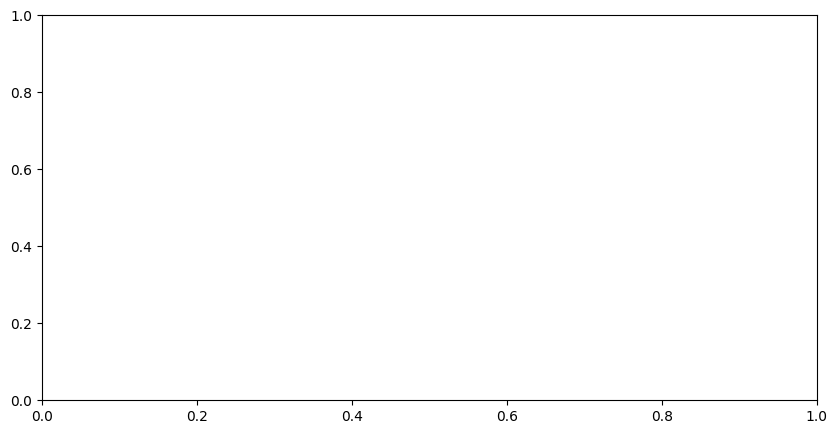

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 14

samples = adata.obs["dpi_clean"]
labels = samples
virus_id = "u55137"

cellnum = []
counts = []
for sample in samples:
    count = adata.X[adata.obs["dpi_clean"] == sample, adata.var.index == virus_id].sum()
    counts.append(count)
    if count > 0:
        cellnum.append(len(nd(adata.X[adata.obs["dpi_clean"] == sample, adata.var.index == virus_id])))
    else:
        cellnum.append(0)

fontsize = 14
width = 0.4
x = np.arange(len(labels))

ax.bar(x-width/2, counts, width=width, label=f"UMI counts", color="#d42526", edgecolor="black")
ax.bar(x+width/2, cellnum, width=width, label=f"EBOV+ cells", color="#d42526", alpha=0.5, edgecolor="black")

ax.set_yscale("log")
ax.set_ylabel("Total count", fontsize=fontsize)
ax.set_xlabel("Timepoint", fontsize=fontsize)
ax.legend(loc="upper left", fontsize=fontsize)

ax.set_xticks(x, samples, rotation=0, ha="center")

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Zaire Ebolavirus ({virus_id}) RdRP RNA molecule and cell counts", fontsize=fontsize+2)

ax.grid(True, which="both", color="lightgray")
ax.set_axisbelow(True)

fig.show()

Define virus filtering thresholds for bar and Krona plots:

In [ ]:
# Minimum count of virus in at least one cell
count_threshold = 2
# Minimum number of cells the virus was seen in
num_cells_threshold = 100

In [ ]:
samples = []

# Get counts for each virus per sample
vir_fractions_df = pd.DataFrame()

for idx, virus_id in enumerate(adata.var.index):
    if adata.X[:, adata.var.index == virus_id].max() >= count_threshold and len(nd(adata.X[:, adata.var.index == virus_id].todense())) >= num_cells_threshold:
        virus_counts = []
        
        for timepoint in timepoints:
            for animal_id in adata.obs[adata.obs["dpi_clean"] == timepoint]["donor_animal"].unique():
                virus_counts.append(adata.X[(adata.obs["donor_animal"] == animal_id) & (adata.obs["dpi_clean"] == timepoint), adata.var.index == virus_id].sum())
                
                if idx == 0:
                    samples.append(timepoint + "_" + animal_id)

        utax_label = "_".join(phylogeny_data[phylogeny_data["Label"] == virus_id].values[0]).replace("_.", "")
        vir_fractions_df[utax_label] = virus_counts

vir_fractions_df["sample"] = samples

# De-fragment dataframe
vir_fractions_df = vir_fractions_df.copy()

# Set sample as index
vir_fractions_df = vir_fractions_df.set_index("sample")

# Get total virus reads per sample
vir_fractions_df["sample_total"] = vir_fractions_df.sum(axis = 1)

# Get fractions for each virus
for virus in vir_fractions_df.columns[:-1]:
    vir_fractions_df[f"{virus}_fraction"] = vir_fractions_df[virus] / vir_fractions_df["sample_total"]
    
# De-fragment dataframe
vir_fractions_df = vir_fractions_df.copy()

# Sort by maximum value accross all samples
vir_fractions_df = vir_fractions_df[vir_fractions_df.max().sort_values(ascending=False).index]

vir_fractions_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fontsize = 14
width = 0.75

samples = vir_fractions_df.index.values
x = np.arange(len(samples))
bottom = np.zeros(len(samples))

NUM_COLORS = 20
color_idx = 0
second_hatch_round = False
third_hatch_round = False
forth_hatch_round = False
hatch=""
mpl.rcParams['hatch.linewidth'] = 0.5
legend_counter = 0

for virus_column in vir_fractions_df.columns:
    if "_fraction" in virus_column:
        label_temp = virus_column.split("_fraction")[0]
        # Split long labels after n characters
        n = 79
        label = ("\n".join(label_temp[i:i+n] for i in range(0, len(label_temp), n))) if len(label_temp) > n else label_temp

        # Only show labels for first n viruses (else legend will be too long / break plot)
        if legend_counter <= 47:
            ax.barh(x, vir_fractions_df[virus_column].values, width, label=label, left=bottom, color=plt.cm.tab20(color_idx), hatch=hatch)
            legend_counter += 1
        else:
            ax.barh(x, vir_fractions_df[virus_column].values, width, left=bottom, color=plt.cm.tab20(color_idx), hatch=hatch)
        
        bottom += vir_fractions_df[virus_column].values

        # Change hatch every 20 viruses
        if color_idx == NUM_COLORS-1 and not second_hatch_round and not third_hatch_round and not forth_hatch_round:
            hatch = "/"
            second_hatch_round = True
            color_idx = 0
            continue
        elif color_idx == NUM_COLORS-1 and second_hatch_round:
            hatch = "\\"
            color_idx = 0
            second_hatch_round = False
            third_hatch_round = True
            continue
        elif color_idx == NUM_COLORS-1 and third_hatch_round:
            hatch = "o"
            color_idx = 0
            third_hatch_round = False
            forth_hatch_round = True
            continue
        elif color_idx == NUM_COLORS-1 and forth_hatch_round:
            hatch = "+"
            color_idx = 0
            continue
        else:
            color_idx += 1

# Add number of total virus counts to plot and generate xtick labels
ax.set_xlim(0, 1.08)
sample_type_label = []
x_height  = 1.005
for i, sample in enumerate(samples):
    total_count = "{:,}".format(vir_fractions_df[vir_fractions_df.index == sample]["sample_total"].values[0].astype(int))  
    ax.annotate(total_count, (x_height, i), fontsize=fontsize-1, ha="left", va="center")
    
    sample_type_label.append(sample)

# ax.set_yscale("log")
ax.set_xlabel("Fraction of total virus reads", fontsize=fontsize)
ax.set_ylabel("Animal", fontsize=fontsize)

# leg = ax.legend(fontsize=fontsize, loc='center left', bbox_to_anchor=(1, 0.5))
leg = ax.legend(fontsize=fontsize-3, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=7)
for i, leg_txt in enumerate(leg.get_texts()):
    leg_txt.set_color("white")
leg.get_frame().set_alpha(0.2)

ax.set_yticks(x, sample_type_label, rotation=0, ha="right")
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Fraction of reads per virus species", fontsize=fontsize+2)
    
ax.margins(y=0.01) 

fig.show()

# Create [Krona](https://github.com/marbl/Krona/wiki) plot 
This plot will be saved as html and can be opened in a browser.

In [ ]:
# Install Krona from source
!git clone https://github.com/marbl/Krona.git && cd Krona && ./install.pl

In [ ]:
master = pd.DataFrame()
for idx, timepoint in enumerate(adata.obs["dpi_clean"].unique()):
    for animal_id in adata.obs[adata.obs["dpi_clean"] == timepoint]["donor_animal"].unique():
        adata_temp = adata[(adata.obs["dpi_clean"] == timepoint) & (adata.obs["donor_animal"] == animal_id), :]

        # Add total number of counts (across all cells) for each virus ID to phylogeny data temp
        virus_ids = adata_temp.var.index.values
        total_counts = nd(adata_temp.X.sum(axis=0))
        total_count_dict = {virus_ids[i]: total_counts[i] for i in range(len(virus_ids))}

        phylogeny_data_temp = phylogeny_data.copy()
        phylogeny_data_temp['total_count'] = phylogeny_data_temp['Label'].map(total_count_dict)

        # Remove all viruses that were only detected in less than num_cells_threshold cells
        phylogeny_data_temp = phylogeny_data_temp[phylogeny_data_temp["total_count"] >= num_cells_threshold]

        # Remove non-relevent columns and change order of columns  
        phylogeny_data_temp = phylogeny_data_temp[["total_count", "phylum", "class", "order", "family", "genus", "species", "Label"]]

        # Replace dots with NaN
        phylogeny_data_temp = phylogeny_data_temp.replace(".", np.nan)

        # Add column with timepoint
        phylogeny_data_temp["timepoint"] = timepoint

        # Add column with animal id
        phylogeny_data_temp["animal_id"] = animal_id

        # Append to master dataframe
        if idx == 0:
            master = phylogeny_data_temp.copy()
        else:
            master = master.append(phylogeny_data_temp)

# Save counts + taxnomomies data to txt file
master.to_csv(f'krona.txt', sep ='\t', header=None, index=False)

# Generate Krona plot
krona_out = "figures/krona.html"
!$ktImportText krona.txt -o $krona_out -n "Viral RNAs"